# Time Series Forecasting with Neural Network Model: S&P 500 index

## Goal: Predict Open / Close Price of the date
* To assist traders to make decision
* Make feature of interest as a function input: can easily be converted to predict Open/Close -> High/Low

## Steps
* Get data: Get data from yahoo finance (last 5 years)


* EDA: Visualization. Missing Data? Outliers?


* Train/Test/Evaluation data split (80% / 10% / 10%)
* Feature Engineering: MinMaxScaler to "Train Data Only"
* Feature Engineering: Conver data to sequential format (to feed them to the LSTM model)


* Model Evaluation: Get MAE, RMS from the test data set --> This is the predicted performance of this model to the evaluation set.
* See if the model works as predicted with evaluation data.

In [49]:
import pandas_datareader as pdr
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
# Import S&P 500 index from Yahoo Finance
df=pdr.get_data_yahoo('^GSPC', )

In [51]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-08-30,2460.310059,2443.770020,2446.060059,2457.590088,2633660000,2457.590088
2017-08-31,2475.010010,2462.649902,2462.649902,2471.649902,3348110000,2471.649902
2017-09-01,2480.379883,2473.850098,2474.419922,2476.550049,2710730000,2476.550049
2017-09-05,2471.969971,2446.550049,2470.350098,2457.850098,3490260000,2457.850098
2017-09-06,2469.639893,2459.199951,2463.830078,2465.540039,3374410000,2465.540039


# Feature definitions
* Date: Date of interest
* High: Highest index within the day
* Low : Lowest index within the day
* Close: Closing index of the date
* Volume: How many shares have traded within the day
* Adj Close: Closing price after adjustments for all applicable splits and dividend distributions

In [52]:
len(df[df['Close']!=df['Adj Close']])

0

In [53]:
# Drop the Adj Close column because it is the same as the Close column
df = df.drop('Adj Close',axis=1)

In [54]:
df.head()

,High,Low,Open,Close,Volume
Date,,,,,
2017-08-30,2460.310059,2443.770020,2446.060059,2457.590088,2633660000
2017-08-31,2475.010010,2462.649902,2462.649902,2471.649902,3348110000
2017-09-01,2480.379883,2473.850098,2474.419922,2476.550049,2710730000
2017-09-05,2471.969971,2446.550049,2470.350098,2457.850098,3490260000
2017-09-06,2469.639893,2459.199951,2463.830078,2465.540039,3374410000


In [55]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
High,1258.0,3.382016e+03,6.967801e+02,2.300730e+03,2.795625e+03,3.110810e+03,4.048433e+03,4.818620e+03
Low,1258.0,3.341300e+03,6.883784e+02,2.191860e+03,2.767005e+03,3.075940e+03,3.966210e+03,4.780040e+03
Open,1258.0,3.362616e+03,6.926935e+02,2.290710e+03,2.785143e+03,3.090015e+03,3.997017e+03,4.804510e+03
Close,1258.0,3.362893e+03,6.927837e+02,2.237400e+03,2.783315e+03,3.093620e+03,4.006270e+03,4.796560e+03
Volume,1258.0,3.914373e+09,1.071109e+09,1.296540e+09,3.264450e+09,3.645475e+09,4.236952e+09,9.878040e+09


# Exploratory Data Analysis and Feature Engineering

## EDA
* Check for missing data
* Visualize

In [56]:
df.isnull().sum()

High      0
Low       0
Open      0
Close     0
Volume    0
dtype: int64

Text(0.5, 1.0, 'S&P 500 Index: Open')

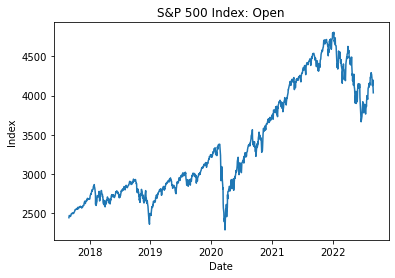

In [57]:
plt.figure()
plt.plot(df['Open'],color='tab:blue')
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('S&P 500 Index: Open')

Text(0.5, 1.0, 'S&P 500 Index Close')

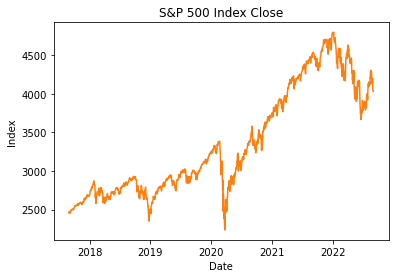

In [58]:
plt.figure()
plt.plot(df['Close'],color='tab:orange')
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('S&P 500 Index Close')

Text(0.5, 1.0, 'Absolute value of Close - Open')

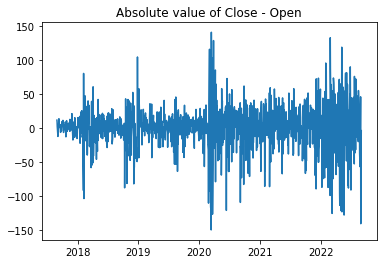

In [59]:
plt.figure()
plt.plot((df['Close']-df['Open']))
plt.title('Absolute value of Close - Open')

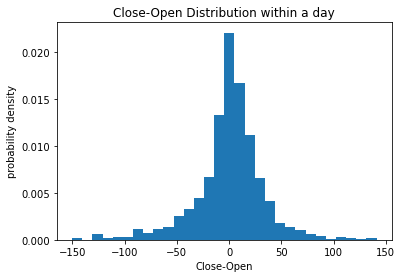

In [60]:
plt.figure()
plt.title("Close-Open Distribution within a day")
plt.xlabel('Close-Open')
plt.ylabel('probability density')
plt.hist(df['Close']-df['Open'],bins=30,density=True);

In [61]:
(df['Close']-df['Open']).mean()

0.277250984325318

In [62]:
(df['Close']-df['Open']).std()

32.61645294445709

## Feature Engineering
* Take Open and Close prices from the dataset


* Scale the data: MinMaxScaler
* Take first 80% for training set
* Take the most recent 30 days for evaluation set
* Left over: test set


* Convert data to a model-feedable form
* Model: Use LSTM. (Advanced version of RNN; specialized in predict future value based on past data)
* Predict the price based on past 30 days: Feed 2D tensor to each date (overall data format will be 3D tensor; date x 30days x features)

### Why MinMax over Standard scaler?
* The price value itself is more relevant than the distribution (Z-score)

## Reference
* I found Colah's post is very helpful for understanding how LSTM performs. I HIGHLY recommend checking this post http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [63]:
# Define a function that reframe data (include past 30 days data)
def make_sequential_data(X,features,num_timesteps):
    """
    Take data X, len_days (number of past days to make a model out of)
    i-th date: data should be 2-D tensor for a day. len_days rows
    The overall data will be (date x num_timesteps x num_features) 3-D tensor
    """
    data=[]
    y=[]
    Y = X[features]
    Y = np.array(Y)
    X = np.array(X)
    for i in range(num_timesteps, len(X)): # range: start point inclusive, end point exclusive (i=30 ~ len(X)-1)
        data.append(X[i-num_timesteps:i]) # -30 days to current date (i-th date), 5 features
        y.append(Y[i]) # i+1-th date: indexing starts from 0
    return np.array(data), np.array(y)

## Scale and Split data (80% training, 10% test, last 10 % for evaluation)
* Make a temporal test data set just to get the statistics to scale the data: prevent leakage from future information
* Check the shape of the re-framed dataset: (num_data, num_timestepts=30, num_features=2)

In [64]:
X_train = df[:int(0.8*len(df))]
len(X_train)

1006

In [65]:
from sklearn.preprocessing import MinMaxScaler

In [67]:
# scaler: instance to scale the input data (4 columns)
scaler = MinMaxScaler()
scaler.fit(X_train)
# scaler2: instance to reverse transform the predicted value to the dollars value (2 columns of interest)
scaler2 = MinMaxScaler()
scaler2.fit(X_train[['Open', 'Close']])

MinMaxScaler()

In [69]:
scaled_data = scaler.transform(df)
scaled_data = pd.DataFrame(data=scaled_data, index=df.index, columns=df.columns)
scaled_data.describe()

,High,Low,Open,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.488695,0.501107,0.486558,0.495382,0.305055
std,0.314915,0.300104,0.314426,0.304926,0.124816
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.223671,0.250739,0.224432,0.240283,0.229320
50%,0.366121,0.385422,0.362819,0.376862,0.273721
75%,0.789886,0.773542,0.774524,0.778562,0.342646
max,1.137978,1.128337,1.141060,1.126406,1.000000


In [70]:
scaled_X, scaled_y = make_sequential_data(scaled_data, features = ['Open', 'Close'], num_timesteps=30)

In [72]:
# Check the shape of the sequential data and output result
print(len(df), len(scaled_X))
print(scaled_X.shape, scaled_y.shape)

1258 1228
(1228, 30, 5) (1228, 2)


In [73]:
# Should have 30 fewer datapoints because first 30 rows were removed from the make_sequential function
scaled_X_train = scaled_X[:round(0.8*len(scaled_X))]
scaled_y_train = scaled_y[:round(0.8*len(scaled_X))]
print(scaled_X_train.shape, scaled_y_train.shape)

(982, 30, 5) (982, 2)


In [74]:
scaled_X_test = scaled_X[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))]
scaled_y_test = scaled_y[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))]
print(scaled_X_test.shape, scaled_y_test.shape)

(123, 30, 5) (123, 2)


In [75]:
scaled_X_eval = scaled_X[-round(0.1*len(scaled_X)):]
scaled_y_eval = scaled_y[-round(0.1*len(scaled_X)):]
print(scaled_X_eval.shape, scaled_y_eval.shape)

(123, 30, 5) (123, 2)


In [76]:
# Check data loss: sum should be 1228
982+123+123

1228

## Model & Prediction

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Open Price prediction model
* Single LSTM layer model
* Double LSTM layer model
* Test under variant cell number

#### Reference: input data shape
https://stackoverflow.com/questions/61153831/how-to-properly-set-the-input-shape-of-lstm-layers

In [78]:
def single_layer_model(scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test, num_cells, epochs):
    model = Sequential()
    # Input shape should be (num_timesteps, num_features)
    model.add(LSTM(units=num_cells, activation='tanh', input_shape=scaled_X_train[0].shape)) 
    model.add(Dense(2)) # Return two values: "Open" and "Close"
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stop condition: no improve for next 10 points
    early_stop = EarlyStopping(monitor="val_loss", patience=10)
    model.fit(scaled_X_train, scaled_y_train, epochs=epochs, 
              validation_data=(scaled_X_test, scaled_y_test),
              callbacks=[early_stop], verbose=0)
    
    plt.figure()
    plt.title(f"Single Layer LSTM with {num_cells} cells")
    plt.plot(model.history.history['loss'], label='Train Loss')
    plt.plot(model.history.history['val_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    
    return model

In [97]:
def model_evaluation(model, scaled_X_test, scaled_y_test, scaler2, num_cells):
    """
    Evaluate the Model with Test set
    """
    plt.figure()
    scaled_y_pred_test = model.predict(scaled_X_test, verbose=0)
    y_test = scaler2.inverse_transform(scaled_y_test)
    y_pred_test = scaler2.inverse_transform(scaled_y_pred_test)
    
    plt.plot(df.index[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))],y_test[:,0],color='tab:blue', label="Real Open Price")
    plt.plot(df.index[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))],y_test[:,1],color='tab:orange', label="Real Close Price")
    plt.plot(df.index[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))],y_pred_test[:,0],color='tab:blue',linestyle='--', label="Predicted Open Price")
    plt.plot(df.index[-round(0.2*len(scaled_X)):-round(0.1*len(scaled_X))],y_pred_test[:,1],color='tab:orange',linestyle='--', label="Predicted Close Price")
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Index')
    plt.title(f'S&P 500 Index Price predicted with {num_cells} LSTM cells')
    plt.legend()
    
    print(f'====== {num_cells} cells LSTM Model ======')
    print(f'Mean Real Open Price: {y_test[:,0].mean().round(2)}')
    print(f'Mean Predicted Open Price: {y_pred_test[:,0].mean().round(2)}')
    print(f'MAE Open: {round(mean_absolute_error(y_test[:,0],y_pred_test[:,0]),2)}')
    print(f'RMS Open: {round(mean_squared_error(y_test[:,0],y_pred_test[:,0])**0.5,2)}')
    print("")
    print(f'Mean Real Close Price: {y_test[:,1].mean().round(2)}')
    print(f'Mean Predicted Close Price: {y_pred_test[:,1].mean().round(2)}')
    print(f'MAE Close: {round(mean_absolute_error(y_test[:,1],y_pred_test[:,1]),2)}')
    print(f'RMS Close: {round(mean_squared_error(y_test[:,1],y_pred_test[:,1])**0.5,2)}')
    print('')
    
    plt.figure()
    plt.title("Real-Prediction PDF")
    plt.axvline(0,0,1, linewidth=1, linestyle='--', label="Perfect Prediction")
    sns.kdeplot(y_test[:,0]-y_pred_test[:,0], color='tab:blue', label="Open Price")
    sns.kdeplot(y_test[:,1]-y_pred_test[:,1], color='tab:orange', label="Close Price")
    plt.legend()

====== 32 cells LSTM Model ======
Mean Real Open Price: 4543.34
Mean Predicted Open Price: 4559.81982421875
MAE Open: 30.71
RMS Open: 40.32

Mean Real Close Price: 4541.39
Mean Predicted Close Price: 4559.91015625
MAE Close: 48.0
RMS Close: 60.31

====== 64 cells LSTM Model ======
Mean Real Open Price: 4543.34
Mean Predicted Open Price: 4572.27978515625
MAE Open: 32.19
RMS Open: 40.18

Mean Real Close Price: 4541.39
Mean Predicted Close Price: 4585.1298828125
MAE Close: 54.44
RMS Close: 69.7

====== 128 cells LSTM Model ======
Mean Real Open Price: 4543.34
Mean Predicted Open Price: 4514.02978515625
MAE Open: 35.01
RMS Open: 41.64

Mean Real Close Price: 4541.39
Mean Predicted Close Price: 4537.4501953125
MAE Close: 43.0
RMS Close: 53.21



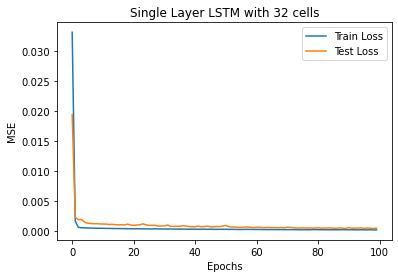

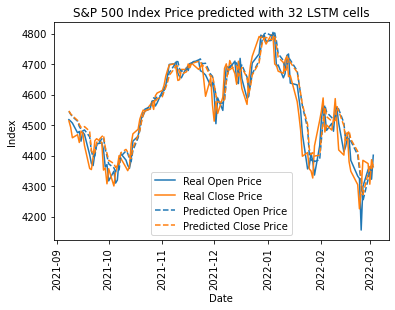

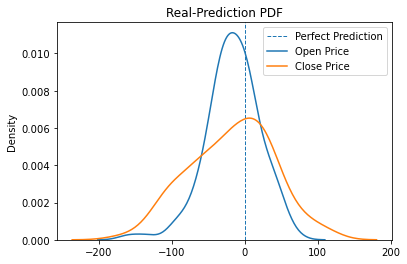

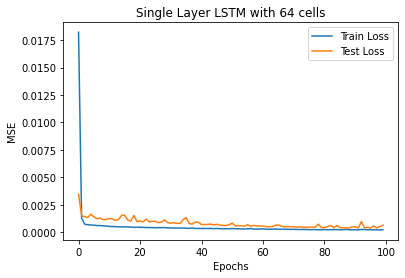

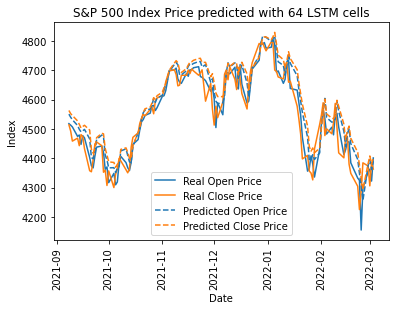

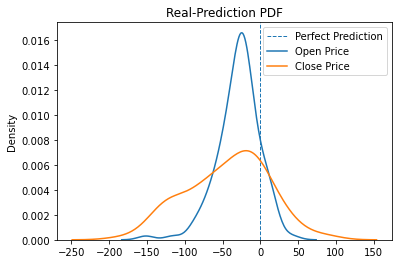

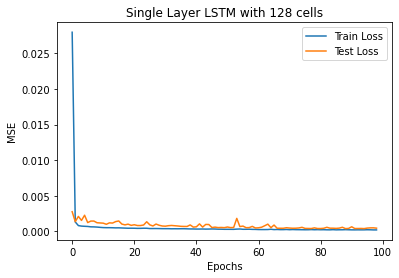

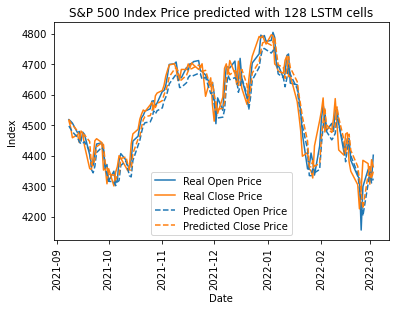

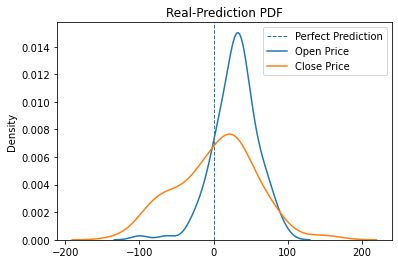

In [96]:
models = []
for num_cells in [32, 64,128]:
    model = single_layer_model(scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test, num_cells, epochs=100)
    models.append(model)
    model_evaluation(model, scaled_X_test, scaled_y_test, scaler2, num_cells)

[ 6.36802899e-03  2.75639009e-03  4.82610918e+00 -8.77170834e+01
  4.58072776e+01  3.75104620e+01]


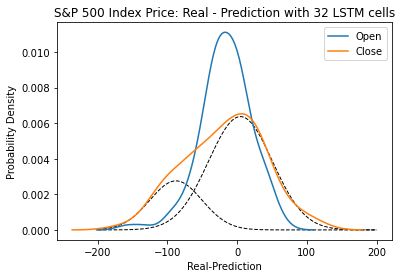

In [147]:
# Select 32 cells model
model = models[0]

# Get y_pred values for the test data
scaled_y_pred_test = model.predict(scaled_X_test, verbose=0)
y_test = scaler2.inverse_transform(scaled_y_test)
y_pred_test = scaler2.inverse_transform(scaled_y_pred_test)

kde_open = sns.kdeplot(y_test[:,0]-y_pred_test[:,0])#, color="tab:blue", label="Open Price")
kde_close = sns.kdeplot(y_test[:,1]-y_pred_test[:,1])#, color='tab:orange', label = 'Close Price')
plt.close()

fig = plt.figure()
plt.xlabel('Real-Prediction')
plt.ylabel('Probability Density')
plt.title('S&P 500 Index Price: Real - Prediction with 32 LSTM cells')

# Open Price
line = kde_open.lines[0]
x_open, y_open = line.get_data()
plt.plot(x_open,y_open, color="tab:blue", label="Open")

# Close Price
line = kde_close.lines[1]
x_close, y_close = line.get_data()
plt.plot(x_close, y_close, color='tab:orange', label='Close')

# Fit Close Price with two Gaussians
from scipy.optimize import curve_fit
def gauss(x, a, m, s):
    return a*np.exp(-(x-m)**2 / (2*s**2))
def two_gauss(x,a1,a2,m1,m2,s1,s2):
    return gauss(x,a1,m1,s1)+gauss(x,a2,m2,s2)

popt, pcov = curve_fit(two_gauss, x_close, y_close, p0=[0.006,0.004,0,-100,40,40])
x=np.linspace(-200,200,400)
plt.plot(x, gauss(x,popt[0],popt[2],popt[4]), linestyle='--', color='k', linewidth=1, zorder=0)
plt.plot(x, gauss(x,popt[1],popt[3],popt[5]), linestyle='--', color='k', linewidth=1, zorder=0)

plt.legend()

print(popt)

## Model Summary
### Model Selection
* No overfitting
* Choose 32 cells model: Use the simpliest model if possible

### Interpret the prediction
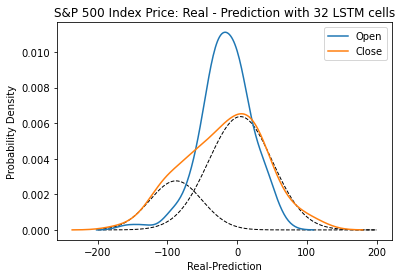

Distribution function of Real value - predicted value is shown above.
Value close to 0 means the prediction is close to the real value.
If model predicts index perfectly, it will show a delta function at x=0.
* The open price is normally distributed with a peak at 0 with std ~40
* The close price consists of two distribution. (Sum of Gaussian centered at x=-90 and x=5)
* Open price follows and is predictable from the historical trend.
* Postulation: Daily events "Degenerate" the Close price. This model only takes historical data, so the daily events cannot be taken into account: Bad(Good) news within the day leads to decrease(increase) of the index from the predicted value and contributes to the left(right) peak.
* Actually, the std of the two peaks (black dashed lines in the figure above) have ~40 std, which is corresponding to the std of the open prediction
__Std(blue) = Std(black curves)__

# Evaluation
* Retrain the model with train + test data: Take the most out of data
* Evaluate the model with evaluation set

In [148]:
scaled_X_train = scaled_X[:round(0.9*len(scaled_X))]
scaled_y_train = scaled_y[:round(0.9*len(scaled_X))]
print(scaled_X_train.shape, scaled_y_train.shape)

(1105, 30, 5) (1105, 2)


In [149]:
model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape=scaled_X_train[0].shape)) 
model.add(Dense(2)) # Return two values: "Open" and "Close"
model.compile(optimizer='adam', loss='mean_squared_error')

epochs=100
early_stop = EarlyStopping(monitor="val_loss", patience=10)
model.fit(scaled_X_train, scaled_y_train, epochs=epochs,
          validation_data=(scaled_X_eval, scaled_y_eval),
          callbacks=[early_stop], verbose=0)

====== 32 cells LSTM Model ======
Mean Real Open Price: 4134.27
Mean Predicted Open Price: 4159.77978515625
MAE Open: 40.15
RMS Open: 51.77

Mean Real Close Price: 4133.61
Mean Predicted Close Price: 4165.60986328125
MAE Close: 66.25
RMS Close: 82.97



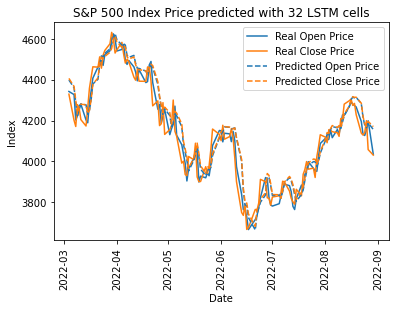

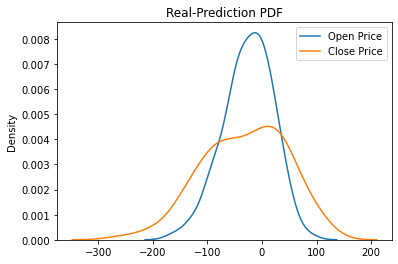

In [150]:
plt.figure()
scaled_y_pred_eval = model.predict(scaled_X_eval, verbose=0)
y_eval = scaler2.inverse_transform(scaled_y_eval)
y_pred_eval = scaler2.inverse_transform(scaled_y_pred_eval)

plt.plot(df.index[-round(0.1*len(scaled_X)):],y_eval[:,0],color='tab:blue', label="Real Open Price")
plt.plot(df.index[-round(0.1*len(scaled_X)):],y_eval[:,1],color='tab:orange', label="Real Close Price")
plt.plot(df.index[-round(0.1*len(scaled_X)):],y_pred_eval[:,0],color='tab:blue',linestyle='--', label="Predicted Open Price")
plt.plot(df.index[-round(0.1*len(scaled_X)):],y_pred_eval[:,1],color='tab:orange',linestyle='--', label="Predicted Close Price")
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('S&P 500 Index Price predicted with 32 LSTM cells')
plt.legend()
    
print('====== 32 cells LSTM Model ======')
print(f'Mean Real Open Price: {y_eval[:,0].mean().round(2)}')
print(f'Mean Predicted Open Price: {y_pred_eval[:,0].mean().round(2)}')
print(f'MAE Open: {round(mean_absolute_error(y_eval[:,0],y_pred_eval[:,0]),2)}')
print(f'RMS Open: {round(mean_squared_error(y_eval[:,0],y_pred_eval[:,0])**0.5,2)}')
print("")
print(f'Mean Real Close Price: {y_eval[:,1].mean().round(2)}')
print(f'Mean Predicted Close Price: {y_pred_eval[:,1].mean().round(2)}')
print(f'MAE Close: {round(mean_absolute_error(y_eval[:,1],y_pred_eval[:,1]),2)}')
print(f'RMS Close: {round(mean_squared_error(y_eval[:,1],y_pred_eval[:,1])**0.5,2)}')
print('')

plt.figure()
plt.title("Real-Prediction PDF")
sns.kdeplot(y_eval[:,0]-y_pred_eval[:,0], color='tab:blue', label="Open Price")
sns.kdeplot(y_eval[:,1]-y_pred_eval[:,1], color='tab:orange', label="Close Price")
plt.legend()

[ 3.42058793e-03  3.54914556e-03  3.21273051e+01 -7.78335884e+01
  4.98004890e+01  6.34482604e+01]


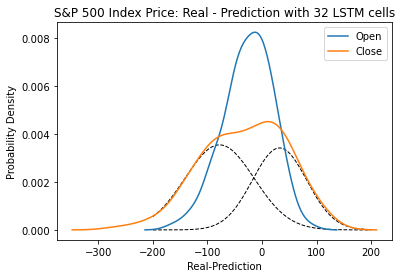

In [152]:
# Get y_pred values for the test data
scaled_y_pred_test = model.predict(scaled_X_eval, verbose=0)
y_eval = scaler2.inverse_transform(scaled_y_eval)
y_pred_eval = scaler2.inverse_transform(scaled_y_pred_eval)

kde_open = sns.kdeplot(y_eval[:,0]-y_pred_eval[:,0])#, color="tab:blue", label="Open Price")
kde_close = sns.kdeplot(y_eval[:,1]-y_pred_eval[:,1])#, color='tab:orange', label = 'Close Price')
plt.close()

fig = plt.figure()
plt.xlabel('Real-Prediction')
plt.ylabel('Probability Density')
plt.title('S&P 500 Index Price: Real - Prediction with 32 LSTM cells')

# Open Price
line = kde_open.lines[0]
x_open, y_open = line.get_data()
plt.plot(x_open,y_open, color="tab:blue", label="Open")

# Close Price
line = kde_close.lines[1]
x_close, y_close = line.get_data()
plt.plot(x_close, y_close, color='tab:orange', label='Close')

# Fit Close Price with two Gaussians
from scipy.optimize import curve_fit
def gauss(x, a, m, s):
    return a*np.exp(-(x-m)**2 / (2*s**2))
def two_gauss(x,a1,a2,m1,m2,s1,s2):
    return gauss(x,a1,m1,s1)+gauss(x,a2,m2,s2)

popt, pcov = curve_fit(two_gauss, x_close, y_close, p0=[0.006,0.004,0,-100,40,40])
x=np.linspace(-200,200,400)
plt.plot(x, gauss(x,popt[0],popt[2],popt[4]), linestyle='--', color='k', linewidth=1, zorder=0)
plt.plot(x, gauss(x,popt[1],popt[3],popt[5]), linestyle='--', color='k', linewidth=1, zorder=0)

plt.legend()

print(popt)

### The similar trend (two peaks) is found from the closing price again

* STD of Blue curve: ~50
* STD of Black curves: ~50 and ~60

# Conclusion

### Model Evaluation

From train/test data, about 40 USD Open and 60 USD Close RMSE were expected. Given that the mean of the real price values are ~$4500, the predictions are quite accurate.

I tested models with 32, 64, and 128 LSTM cells. None of them underwent overfitting (No exploding test loss). A model with 32 cells was chosen to make the model as simple as possible.

The model is retrained with Train+Test data and deployed. The model is evaluated with "unseen" evaluation data. The model predicted the open price as expected from the train/test evaluation. Close price are less predictable and higher error were observed.

====== 32 cells LSTM Model (Train/Test) ======
* Mean Real Open Price: 4543.34
* Mean Predicted Open Price: 4559.81982421875
* MAE Open: 30.71
* RMS Open: 40.32

* Mean Real Close Price: 4541.39
* Mean Predicted Close Price: 4559.91015625
* MAE Close: 48.0
* RMS Close: 60.31

====== 32 cells LSTM Model (Evaluation set)======
* Mean Real Open Price: 4134.27
* Mean Predicted Open Price: 4159.77978515625
* MAE Open: 40.15
* RMS Open: 51.77

* Mean Real Close Price: 4133.61
* Mean Predicted Close Price: 4165.60986328125
* MAE Close: 66.25
* RMS Close: 82.97 

### Probability Density Function of Prediction - Real prices

In general, model performed better when it predicts open price. The PDF of real-prediction value shows wider distribution with close values.

From the distribution function of the real-pred of close price, however, I found a possibility to improve the prediction power of the model. The distribution can be fitted with two gaussian curves. I postulated that when the LSTM model predict the closing price, it should perform as good as open price prediction. However, events that happen within the day (time between open and close) affects the price, and degenerate the final value. (The two black dashed lines originated from single gaussian function) I could actually found that the std of the black curves are similar to the std value of the blue curve. 

Therefore, if I can find a signal that causes the degeneration, I expect that I will be able to improve the performance.

__Train-Test__
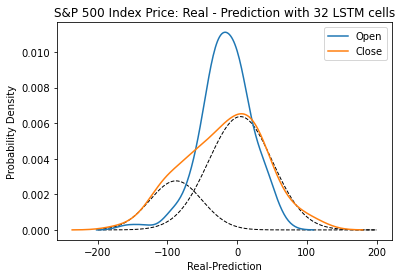

__Final model-evaluation__
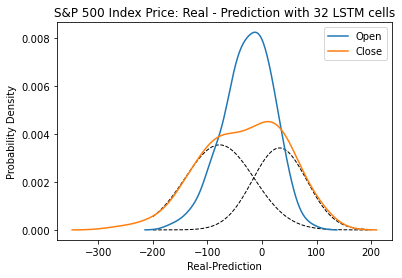